In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams,font_manager
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as patches
import matplotlib.colors as colors
import os
import scipy.stats as sts
import warnings

In [2]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

In [432]:
def load_data(direc,f):
    df = pd.read_csv(direc +f, header=None,
                     names=['idx','subject_id','color','eyecal_m','mi',
                            'status','bp','wp','m','rt','timestamp','a','b']).drop(columns=['idx','a','b','eyecal_m'])
    df = df[df['status']!='eyecal']
    df['subject_id'] = f.split('_')[1].split('.')[0]
    return df

direc = 'C:/Users/svo/Documents/FourinarowData/Raw Data/'
fig_direc = 'G:/My Drive/Bas Games/Figures/'

untrained_df = pd.concat([load_data(direc + 'Untrained/', f) for f in os.listdir(direc + 'Untrained/')]).reset_index(drop=True)
untrained_df['condition'] = 'novice'
untrained_df['subject_id'] = untrained_df['subject_id']+'_n'
trained_df = pd.concat([load_data(direc + 'Trained/', f) for f in os.listdir(direc + 'Trained/')]).reset_index(drop=True)
trained_df['condition'] = 'expert'
trained_df['subject_id'] = trained_df['subject_id']+'_e'

df = pd.concat([untrained_df,trained_df]).reset_index(drop=True)
board_df = pd.read_csv(direc + 'board_stat.txt',header=None,names=['bp','wp','is_real',],sep=' ')
board_id_dict = {board_id:i for i,board_id in enumerate(np.unique(board_df['bp']+board_df['wp']))}
is_real_dict = {board_id:is_real for board_id,is_real in zip(board_df['bp']+board_df['wp'],board_df['is_real'])}

df.loc[df['status']=='reconi','board_id'] = (df[df['status']=='reconi']['bp'] +df[df['status']=='reconi']['wp']).map(board_id_dict).astype(int)
df.loc[df['status']=='reconi','is_real'] = (df[df['status']=='reconi']['bp'] +df[df['status']=='reconi']['wp']).map(is_real_dict).astype(bool)

k = board_id_dict['000000000000001000000101000000111000011010000100100000000000000000000100']
df.loc[(df['status']=='reconi') & (df['board_id']>k),'board_id']+=1
for s in np.unique(df['subject_id']):
    df.loc[(df['subject_id']==s) & (df['status']=='reconi') & (df['board_id']==k),'board_id']=[k,k+1]
    
df['board_id'] = df['board_id'].fillna(method='ffill')
df['is_real'] = df['is_real'].fillna(method='ffill')
df['timestamp'] /=1000 
df.loc[df['status']=='reconi','trial_start']=df[df['status']=='reconi']['timestamp']
df['trial_start'] = df['trial_start'].fillna(method='ffill')
df.loc[df['status']=='reconf','trial_end']=df[df['status']=='reconf']['timestamp']
df['trial_end'] = df['trial_end'].fillna(method='bfill')
df['time_in_trial'] = (df['timestamp']-df['trial_start'])
df['percent_time'] = df['time_in_trial']/(df['trial_end']-df['trial_start'])
bp = np.vstack(df['bp'].apply(lambda s: [int(x) for x in s]))
wp = np.vstack(df['wp'].apply(lambda s: [int(x) for x in s]))
df['is_remove'] = False
df.loc[df.status=='recon','is_remove'] = (wp+bp)[df.status=='recon',df.m[df.status=='recon']]==0


In [433]:
percent_remove_by_subject = 100*df.groupby('subject_id')['is_remove'].mean()
print(percent_remove_by_subject.mean(),percent_remove_by_subject.sem())

7.311909698234138 0.5261983558414772


In [434]:
#{board_id_dict[board_id]:i for i,board_id in enumerate(np.unique((df[(df['status']=='reconi')]['bp']+df[(df['status']=='reconi')]['wp'])))}

In [435]:
df

,subject_id,color,mi,status,bp,wp,m,rt,timestamp,condition,board_id,is_real,trial_start,trial_end,time_in_trial,percent_time,is_remove
0,AC_n,0,0,reconi,000011100001001010000101000000000010,000000010010010100000010110000001100,99,1199,1.465932e+09,novice,40.0,True,1.465932e+09,1.465932e+09,0.000,0.000000,False
1,AC_n,0,0,recon,000010000000000000000000000000000000,000000000000000000000000000000000000,4,1199,1.465932e+09,novice,40.0,True,1.465932e+09,1.465932e+09,3.715,0.087744,False
2,AC_n,0,1,recon,000011000000000000000000000000000000,000000000000000000000000000000000000,5,1199,1.465932e+09,novice,40.0,True,1.465932e+09,1.465932e+09,5.313,0.125487,False
3,AC_n,0,2,recon,000011100000000000000000000000000000,000000000000000000000000000000000000,6,1199,1.465932e+09,novice,40.0,True,1.465932e+09,1.465932e+09,6.145,0.145138,False
4,AC_n,0,3,recon,000011100000001000000000000000000000,000000000000000000000000000000000000,14,1199,1.465932e+09,novice,40.0,True,1.465932e+09,1.465932e+09,10.025,0.236779,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63351,YZ_e,1,14,recon,000101000010010100000000000010010100,000000000000000000001001000000000000,20,2235,1.455917e+09,expert,50.0,False,1.455917e+09,1.455917e+09,11.783,0.805841,False
63352,YZ_e,1,15,recon,000101000010010100000000000010010100,000000000000000000001101000000000000,21,2235,1.455917e+09,expert,50.0,False,1.455917e+09,1.455917e+09,12.174,0.832581,False
63353,YZ_e,1,16,recon,000101000010010100000000000010010100,000000000000000000001101000001000000,29,2235,1.455917e+09,expert,50.0,False,1.455917e+09,1.455917e+09,13.422,0.917932,False
63354,YZ_e,1,17,recon,000101000010010100000000000010010100,000000000000000000001101000001100000,30,2235,1.455917e+09,expert,50.0,False,1.455917e+09,1.455917e+09,13.831,0.945903,False


In [665]:
df['timestamp'].max()

1490993504.624

In [436]:
def get_accuracy(playertype,gametype):
    is_real = gametype=='games'
    
    original_bp = np.vstack(df[(df['status']=='reconi') & (df['condition']==playertype) & (df['is_real']==is_real)]['bp'].apply(lambda s: [int(x) for x in s]))
    original_wp = np.vstack(df[(df['status']=='reconi') & (df['condition']==playertype) & (df['is_real']==is_real)]['wp'].apply(lambda s: [int(x) for x in s]))
    reconstr_bp = np.vstack(df[(df['status']=='reconf') & (df['condition']==playertype) & (df['is_real']==is_real)]['bp'].apply(lambda s: [int(x) for x in s]))
    reconstr_wp = np.vstack(df[(df['status']=='reconf') & (df['condition']==playertype) & (df['is_real']==is_real)]['wp'].apply(lambda s: [int(x) for x in s]))
    original = original_bp - original_wp
    reconstructed = reconstr_bp - reconstr_wp
    return [[np.mean(reconstructed[original==i]==j) for i in [0,-1,1]] for j in [0,-1,1]]

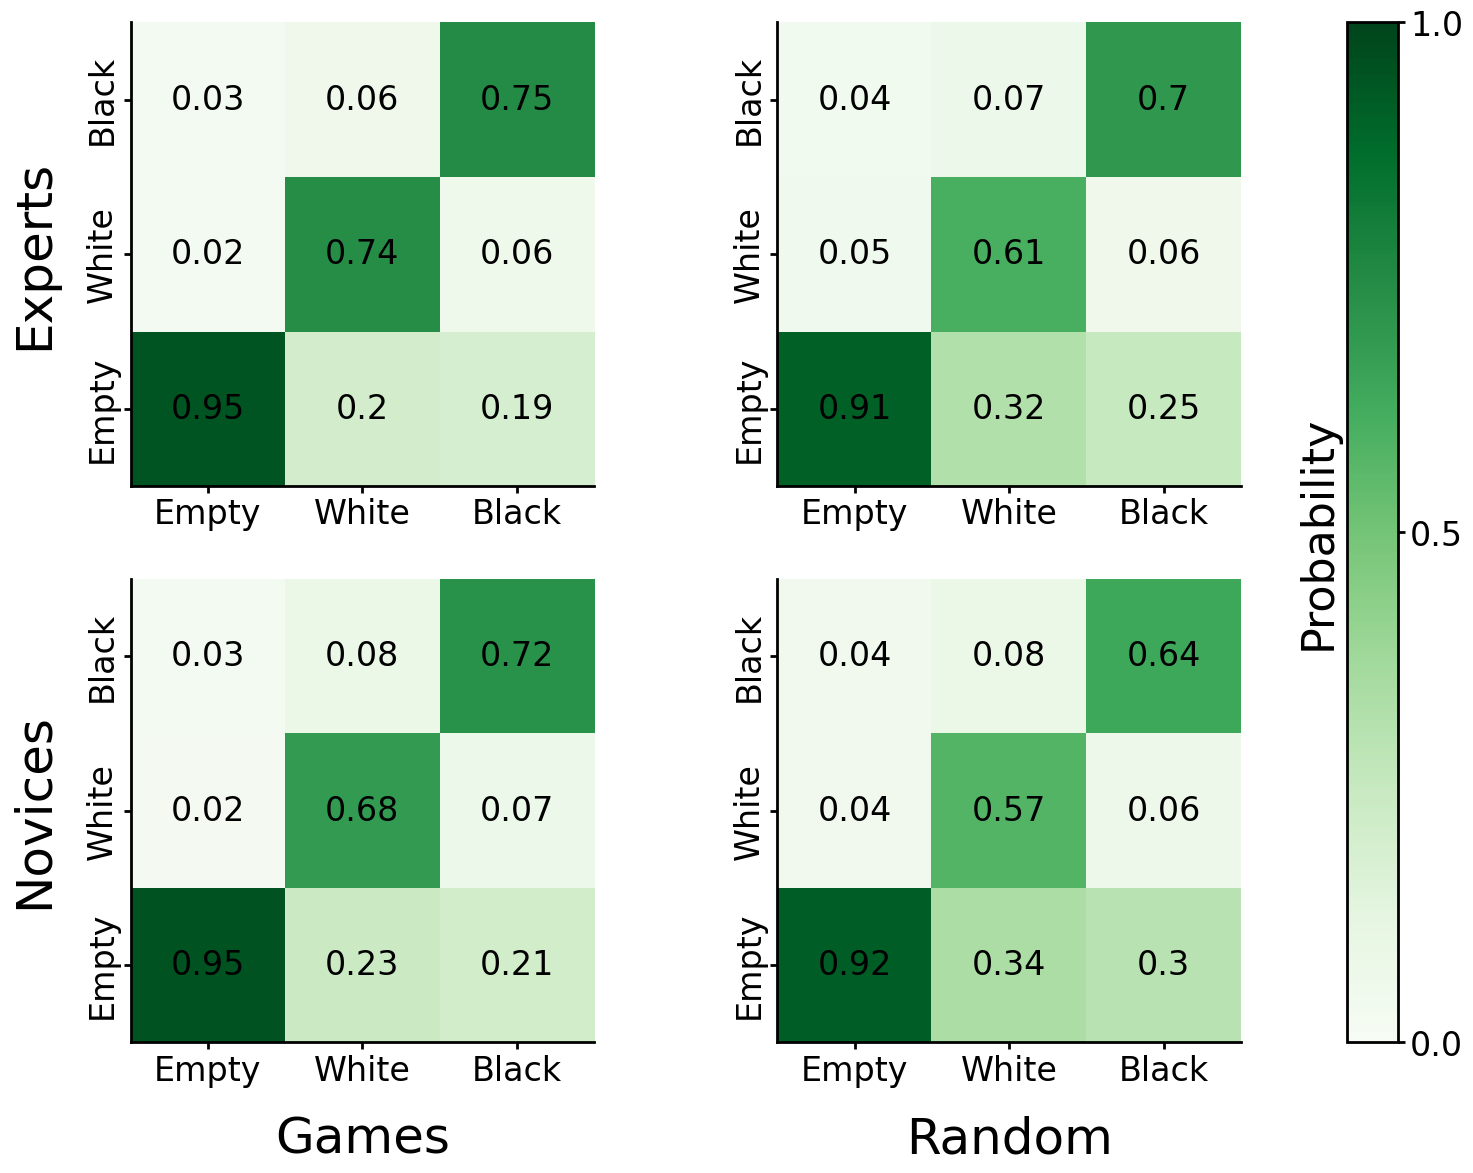

In [437]:
fig,axes = plt.subplots(2,2,figsize=(16,12))
axes[0][0].set_ylabel('Experts',fontsize=36,labelpad=20)
axes[1][0].set_ylabel('Novices',fontsize=36,labelpad=20)
axes[1][0].set_xlabel('Games',fontsize=36,labelpad=20)
axes[1][1].set_xlabel('Random',fontsize=36,labelpad=20)

for k,playertype in enumerate(['expert','novice']):
    for l,gametype in enumerate(['games','random']):
        ax=axes[k][l]
        ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
        x = get_accuracy(playertype,gametype)
        
        im = ax.imshow(x,cmap='Greens',vmin=0,vmax=1,origin='lower')
        for i in [0,1,2]:
            for j in [0,1,2]:
                ax.text(x=j,y=i,s=x[i][j].round(2),ha='center',va='center',fontsize=24)
        ax.set_xticks([0,1,2])
        ax.set_xticklabels(['Empty','White','Black'])
        ax.set_yticks([0,1,2])
        ax.set_yticklabels(['Empty','White','Black'],rotation=90,va='center')
        #ax.set_xlabel('True piece',fontsize=48)
        #ax.set_ylabel('Reconstructed\npiece',fontsize=48)
        #ax.set_title(playertype + '-' + gametype)


fig.subplots_adjust(bottom=0.1,left=0.05,right=1,top=0.95)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(),pad=0.07)
cbar.ax.set_ylabel('Probability',labelpad=-120)
cbar.set_ticks(np.arange(0, 1.1, 0.5))

fig.savefig(fig_direc + 'figure_rev2_1a.pdf')
plt.show()

In [438]:
A = np.array([[get_accuracy(playertype,gametype) 
               for playertype in ['expert','novice']] 
              for gametype in ['games','random']])

In [439]:
get_accuracy('novice','games')

[[0.9520093839249286, 0.23135964912280702, 0.2074561403508772],
 [0.02177682578539372, 0.6843671679197995, 0.07192982456140351],
 [0.026213790289677682, 0.08427318295739349, 0.7206140350877193]]

In [440]:
false_piece_rate = np.sum(A[:,:,1:,0],axis=2)
missed_piece_rate = np.mean(A[:,:,0,1:],axis=2)
wrong_color_rate = (A[:,:,2,1]+A[:,:,1,2])/2


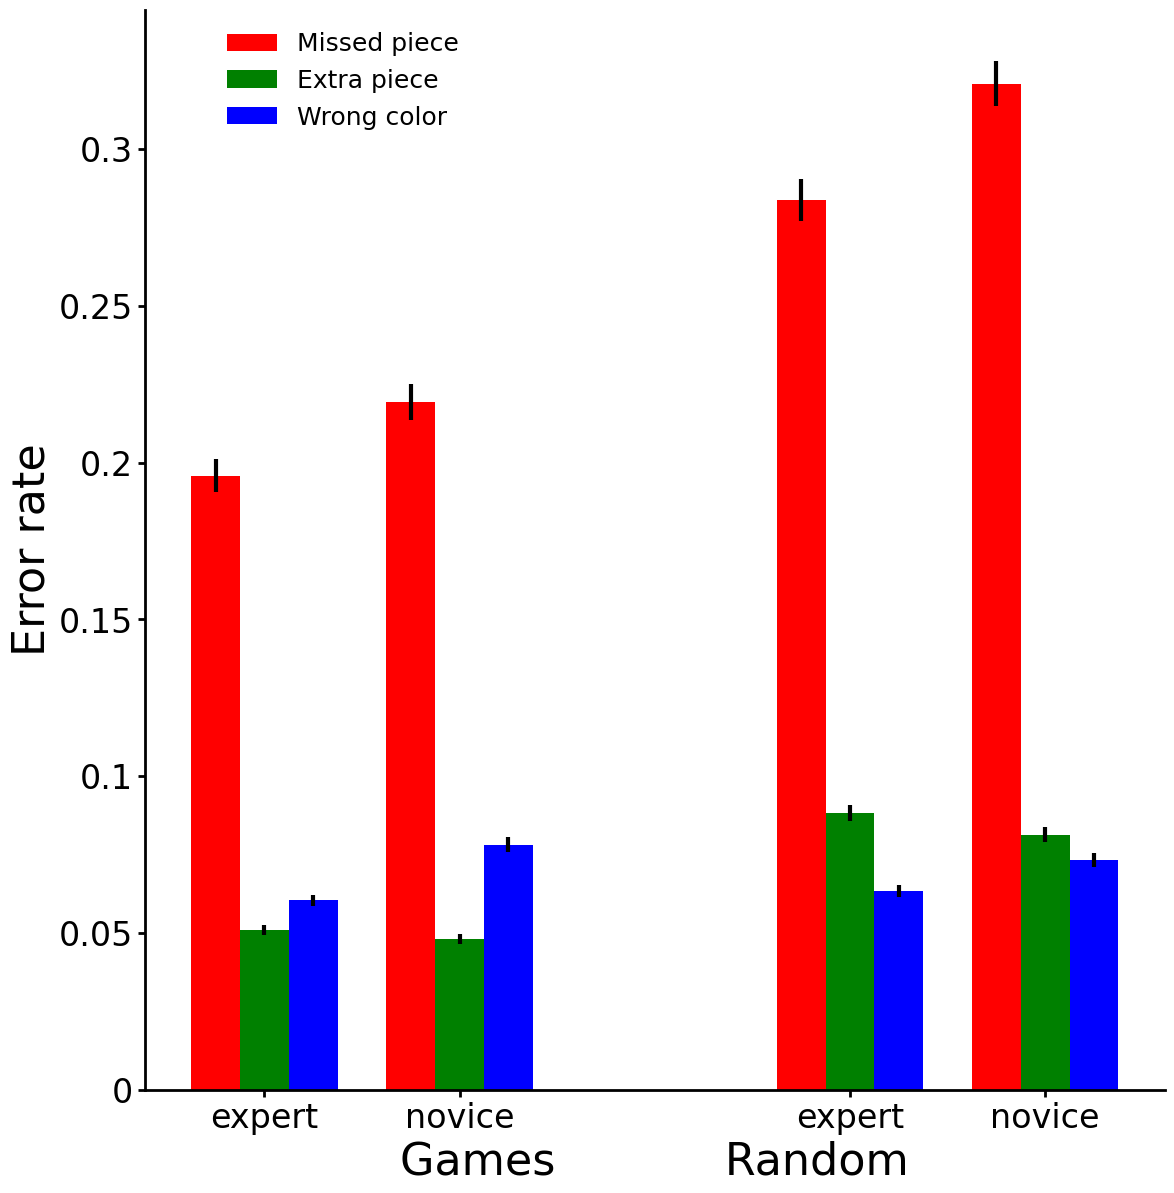

In [661]:
fig,ax = plt.subplots(figsize=(12,12))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

x = np.array([1,2,4,5])
w = 0.25
ax.bar(x = x-w,width=w,height = missed_piece_rate.flatten(),color='red',label='Missed piece')
ax.bar(x = x,width=w,height = false_piece_rate.flatten(),color='green',label='Extra piece')
ax.bar(x = x+w,width=w,height = wrong_color_rate.flatten(),color='blue',label='Wrong color')
ax.errorbar(x = x-w,y = missed_piece_rate.flatten(),color='black',linestyle='none',
            yerr = missed_piece_rate.flatten()*(1-missed_piece_rate.flatten())/np.sqrt(19*48))
ax.errorbar(x = x,y = false_piece_rate.flatten(),color='black',linestyle='none',
            yerr = false_piece_rate.flatten()*(1-false_piece_rate.flatten())/np.sqrt(19*48))
ax.errorbar(x = x+w,y = wrong_color_rate.flatten(),color='black',linestyle='none',
            yerr = wrong_color_rate.flatten()*(1-wrong_color_rate.flatten())/np.sqrt(19*48))

ax.set_xticks(x)
ax.set_xticklabels(['expert','novice','expert','novice'])
ax.set_xlabel('Games            Random')
ax.set_ylabel('Error rate')
fig.legend(bbox_to_anchor=(0.2, 1), loc="upper left")
fig.subplots_adjust(left=0.15,bottom=0.1,right=1,top=1)
fig.savefig(fig_direc + 'figure_rev2_1a.pdf')
plt.show()

In [442]:
#original_df = df[(df['status']=='reconi')].reset_index()

#ind = original_df[(original_df['bp']=='000010000000100000000111000001000000') & (original_df['wp']=='001000000001010000001000100000000000')].index
#df[(df['status']=='reconf')].reset_index().loc[ind]

In [445]:
fourinarows = np.array([[ 0,  9, 18, 27], #hard-coding all ways in which four-in-a-row can appear
                       [ 1, 10, 19, 28],
                       [ 2, 11, 20, 29],
                       [ 3, 12, 21, 30],
                       [ 4, 13, 22, 31],
                       [ 5, 14, 23, 32],
                       [ 6, 15, 24, 33],
                       [ 7, 16, 25, 34],
                       [ 8, 17, 26, 35],
                       [ 0, 10, 20, 30],
                       [ 1, 11, 21, 31],
                       [ 2, 12, 22, 32],
                       [ 3, 13, 23, 33],
                       [ 4, 14, 24, 34],
                       [ 5, 15, 25, 35],
                       [ 3, 11, 19, 27],
                       [ 4, 12, 20, 28],
                       [ 5, 13, 21, 29],
                       [ 6, 14, 22, 30],
                       [ 7, 15, 23, 31],
                       [ 8, 16, 24, 32],
                       [ 0,  1,  2,  3],
                       [ 1,  2,  3,  4],
                       [ 2,  3,  4,  5],
                       [ 3,  4,  5,  6],
                       [ 4,  5,  6,  7],
                       [ 5,  6,  7,  8],
                       [ 9, 10, 11, 12],
                       [10, 11, 12, 13],
                       [11, 12, 13, 14],
                       [12, 13, 14, 15],
                       [13, 14, 15, 16],
                       [14, 15, 16, 17],
                       [18, 19, 20, 21],
                       [19, 20, 21, 22],
                       [20, 21, 22, 23],
                       [21, 22, 23, 24],
                       [22, 23, 24, 25],
                       [23, 24, 25, 26],
                       [27, 28, 29, 30],
                       [28, 29, 30, 31],
                       [29, 30, 31, 32],
                       [30, 31, 32, 33],
                       [31, 32, 33, 34],
                       [32, 33, 34, 35]],dtype=int)

In [446]:
threeinarows = np.vstack([fourinarows,fourinarows[:,[0,2,3,1]],fourinarows[:,[0,1,3,2]],fourinarows[:,[1,2,3,0]]])
twoinarows_conn = np.vstack([fourinarows,fourinarows[:,[1,2,0,3]],fourinarows[:,[2,3,0,1]]])
twoinarows_unc = np.vstack([fourinarows[:,[1,3,0,2]],fourinarows[:,[0,2,1,3]],fourinarows[:,[0,3,1,2]]])

In [447]:
black_3inarows = np.logical_and(np.sum(bp[:,threeinarows[:,:3]],axis=2)==3,np.sum(wp[:,threeinarows[:,3:]],axis=2)==0)
white_3inarows =  np.logical_and(np.sum(wp[:,threeinarows[:,:3]],axis=2)==3,np.sum(bp[:,threeinarows[:,3:]],axis=2)==0)
black_twoinarows_conn = np.logical_and(np.sum(bp[:,twoinarows_conn[:,:2]],axis=2)==2,np.sum(wp[:,twoinarows_conn[:,2:]],axis=2)==0)
white_twoinarows_conn =  np.logical_and(np.sum(wp[:,twoinarows_conn[:,:2]],axis=2)==2,np.sum(bp[:,twoinarows_conn[:,2:]],axis=2)==0)
black_twoinarows_unc = np.logical_and(np.sum(bp[:,twoinarows_unc[:,:2]],axis=2)==2,np.sum(wp[:,twoinarows_unc[:,2:]],axis=2)==0)
white_twoinarows_unc =  np.logical_and(np.sum(wp[:,twoinarows_unc[:,:2]],axis=2)==2,np.sum(bp[:,twoinarows_unc[:,2:]],axis=2)==0)

In [651]:
def plot_board(status,board_id,condition,highlight,filename):

    cm = colors.LinearSegmentedColormap.from_list('gray_gold_map', [colors.to_rgb('darkgray'), 
                                                                    colors.to_rgb('gold')], N=100)
    fig = plt.figure(figsize=[9,4])
    ax = fig.add_subplot(111,aspect='equal')
    ax.vlines(np.arange(-0.5,9.5,1),-0.5,3.5,color='black')
    ax.hlines(np.arange(-0.5,4.5,1),-0.5,8.5,color='black')

    bp = np.vstack(df[(df['status']==status) & (df['board_id']==board_id) & (df['condition']==condition)]['bp'].apply(
        lambda s: [int(x) for x in s])).mean(axis=0)
    wp = np.vstack(df[(df['status']==status) & (df['board_id']==board_id) & (df['condition']==condition)]['wp'].apply(
        lambda s: [int(x) for x in s])).mean(axis=0)

    for p in range(36):
        if bp[p]>0:
            w = patches.Wedge((p%9,p//9),0.33,90,360*bp[p]+90,color='black')
            w = ax.add_patch(w)
        if wp[p]>0:
            w = patches.Wedge((p%9,p//9),0.33,90-360*wp[p],90,color='white')
            w = ax.add_patch(w)
        if bp[p]>0 or wp[p]>0:
            circ = patches.Circle((p%9,p//9),0.33,color="black",fill=False)
            circ = ax.add_patch(circ)

    #for p in black_pieces:
    #    circ = patches.Circle((p%9,p//9),0.33,color="black",fill=True)
    #    circ = ax.add_patch(circ)
    #for p in white_pieces:
    #    circ = patches.Circle((p%9,p//9),0.33,color="white",fill=True)
    #    circ = ax.add_patch(circ)
    #for p in [response]:
    #    circ = patches.Circle((p%9,p//9),0.33,color=color,fill=False)
    #    circ = ax.add_patch(circ)
    plt.imshow(np.isin(range(36),highlight).reshape([4,9]), cmap=cm, 
               interpolation='nearest',origin='lower',vmin=0,vmax=0.2)
    ax.axis('off')
    fig.subplots_adjust(left=0,bottom=0.05,right=1,top=0.95)    
    fig.savefig(fig_direc + filename)
    plt.show()

In [652]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    feature = np.concatenate([black_3inarows,white_3inarows],axis=1)
               
    original = feature[df['status']=='reconi']
    reconstructed = feature[df['status']=='reconf']
    correct_recon = np.logical_and(reconstructed,original)
    percent_correct_expert = np.vstack([np.mean(correct_recon[(df_regression['condition']=='expert') & 
                                                              (df_regression['board_id']==n)],axis=0) 
                       for n in range(96)])
    percent_correct_novice = np.vstack([np.mean(correct_recon[(df_regression['condition']=='novice') & 
                                                              (df_regression['board_id']==n)],axis=0) 
                       for n in range(96)])
    x = np.max(percent_correct_expert - percent_correct_novice,axis=1)
    feature_id = np.argmax(percent_correct_expert - percent_correct_novice,axis=1)
    #x = np.max(reconstructed_expert_white*original_white+reconstructed_expert_black*original_black-
    #           reconstructed_novice_black*original_black-reconstructed_novice_white*original_white,axis=1)
    #feature_id = np.argmax(reconstructed_expert_white*original_white+reconstructed_expert_black*original_black-
    #           reconstructed_novice_black*original_black-reconstructed_novice_white*original_white,axis=1)

76 0.6842105263157895 0.2631578947368421


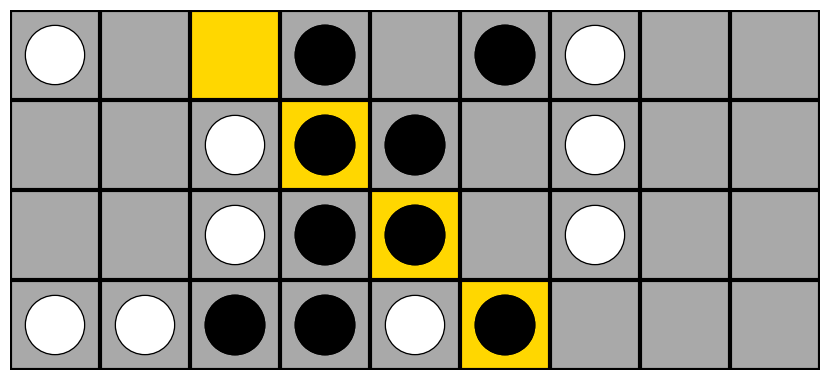

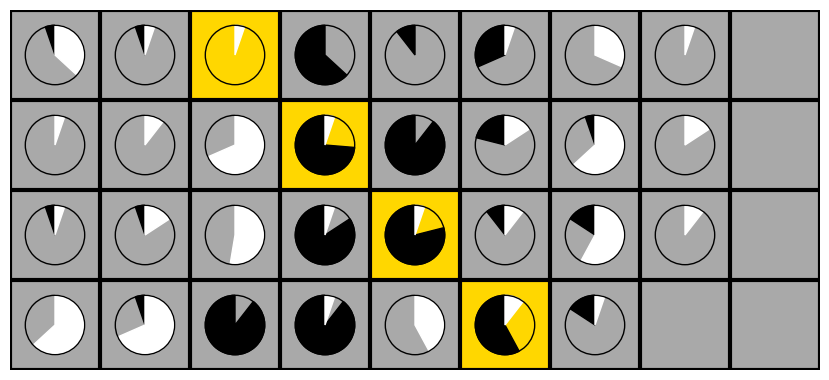

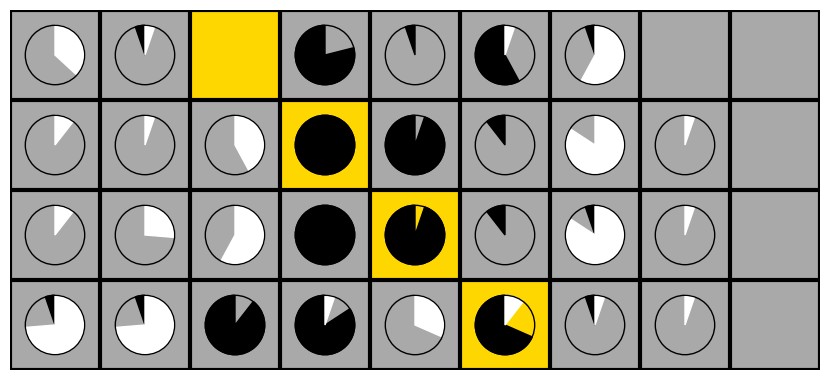

2 0.8421052631578947 0.42105263157894735


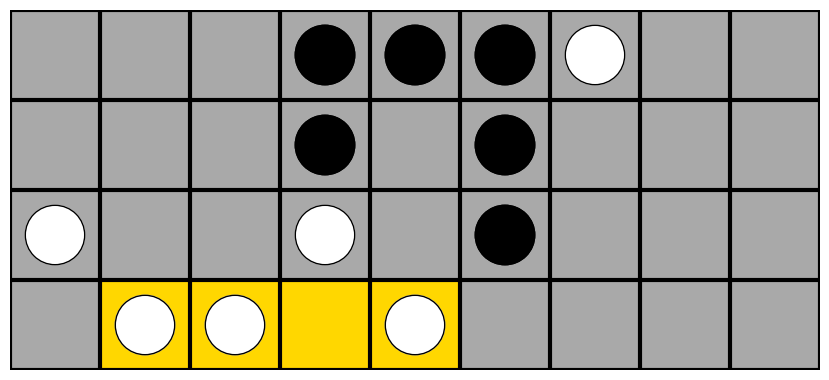

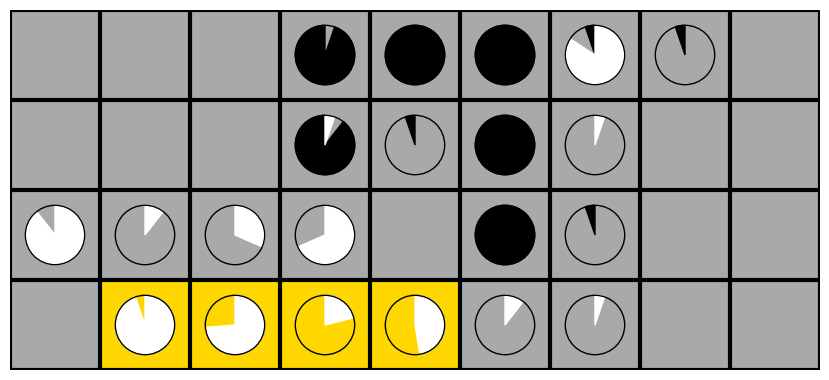

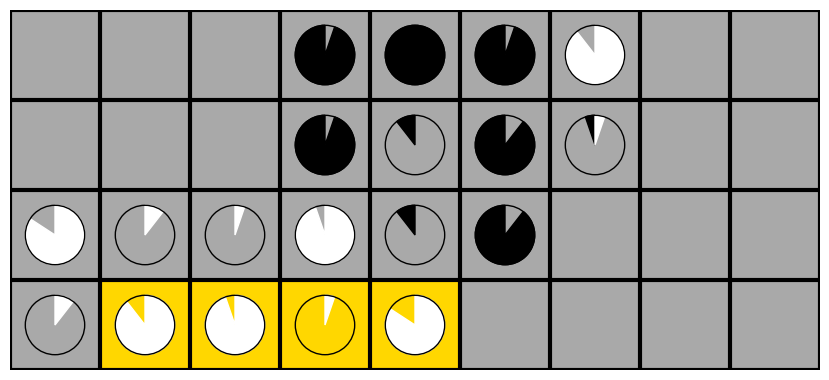

In [655]:
for board_id in np.argsort(-x)[0:2]:
    print(board_id,
          percent_correct_expert[board_id,feature_id[board_id]],
          percent_correct_novice[board_id,feature_id[board_id]])
    plot_board('reconi',board_id,'expert',fourinarows[feature_id[board_id]%45],'figure_rev2_3a.pdf')
    plot_board('reconf',board_id,'novice',fourinarows[feature_id[board_id]%45],'figure_rev2_3b.pdf')
    plot_board('reconf',board_id,'expert',fourinarows[feature_id[board_id]%45],'figure_rev2_3c.pdf')

In [556]:
def generate_first_in_trial(feature,column):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        for i,(istart,iend) in enumerate(zip(df[df['status']=='reconi'].index,
                                             df[df['status']=='reconf'].index)):

            fpresent = feature[istart]
            ffinal = feature[iend]
            reconstructed_black = feature[istart+1:iend]
            reconstructed_black = reconstructed_black[:,np.logical_and(fpresent,ffinal)]
            yield np.mean(df[column][istart + np.argmax(reconstructed_black,axis=0)])    

In [557]:
def get_accuracy(feature):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        original = feature[df['status']=='reconi']
        reconstructed = feature[df['status']=='reconf']
        
        return np.sum(reconstructed*original,axis=1)/np.sum(original,axis=1)

In [559]:
df_regression = df[df['status']=='reconi'][['subject_id','condition','board_id','is_real']]
df_regression['time'] = df[df['status']=='reconf']['time_in_trial'].values

original_bp = np.vstack(df[(df['status']=='reconi')]['bp'].apply(lambda s: [int(x) for x in s]))
original_wp = np.vstack(df[(df['status']=='reconi')]['wp'].apply(lambda s: [int(x) for x in s]))
reconstr_bp = np.vstack(df[(df['status']=='reconf')]['bp'].apply(lambda s: [int(x) for x in s]))
reconstr_wp = np.vstack(df[(df['status']=='reconf')]['wp'].apply(lambda s: [int(x) for x in s]))
original = original_bp - original_wp
reconstructed = reconstr_bp - reconstr_wp

df_regression['missed'] = np.sum((reconstructed==0)*(original!=0),axis=1)/np.sum(original!=0,axis=1)
df_regression['wrong'] = np.mean((reconstructed!=original)*(original!=0),axis=1)
df_regression['extra'] = np.sum((reconstructed!=0)*(original==0),axis=1)/np.sum(original==0,axis=1)
df_regression['accuracy'] = np.mean(reconstructed==original,axis=1)

df_regression['accuracy_3inarow'] = get_accuracy(np.concatenate([black_3inarows,white_3inarows],axis=1))
df_regression['accuracy_2inarowconn'] = get_accuracy(np.concatenate([black_twoinarows_conn,white_twoinarows_conn],axis=1))
df_regression['accuracy_2inarowunc'] = get_accuracy(np.concatenate([black_twoinarows_unc,white_twoinarows_unc],axis=1))

df_regression['first_time_3inarow'] = list(generate_first_in_trial(np.concatenate([black_3inarows,white_3inarows],axis=1),'time_in_trial'))
df_regression['first_time_2inarowconn'] = list(generate_first_in_trial(np.concatenate([black_twoinarows_conn,white_twoinarows_conn],axis=1),'time_in_trial'))
df_regression['first_time_2inarowunc'] = list(generate_first_in_trial(np.concatenate([black_twoinarows_unc,white_twoinarows_unc],axis=1),'time_in_trial'))

df_regression['percent_time_3inarow'] = list(generate_first_in_trial(np.concatenate([black_3inarows,white_3inarows],axis=1),'percent_time'))
df_regression['percent_time_2inarowconn'] = list(generate_first_in_trial(np.concatenate([black_twoinarows_conn,white_twoinarows_conn],axis=1),'percent_time'))
df_regression['percent_time_2inarowunc'] = list(generate_first_in_trial(np.concatenate([black_twoinarows_unc,white_twoinarows_unc],axis=1),'percent_time'))

regression_direc = 'G:/My Drive/Bas Games/Analysis/'
df_regression.to_csv(regression_direc + 'Regressions/reconstruction_accuracy.csv')

In [543]:
df_regression

,subject_id,condition,board_id,is_real,accuracy_3inarow,accuracy_2inarowconn,accuracy_2inarowunc,first_time_3inarow,first_time_2inarowconn,first_time_2inarowunc,time,accuracy,missed,wrong,extra
0,AC_n,novice,40.0,True,1.0,0.833333,1.0,5.313,8.682200,5.3130,42.339,0.983333,0.0,0.000000,0.016713
21,AC_n,novice,8.0,False,1.0,1.000000,1.0,4.545,3.394786,4.6560,32.428,1.000000,0.0,0.000000,0.000000
41,AC_n,novice,80.0,True,1.0,0.666667,1.0,3.480,3.257000,3.4800,43.479,1.000000,0.0,0.000000,0.000000
67,AC_n,novice,16.0,True,0.0,0.200000,0.0,NaN,3.410000,NaN,23.871,0.988889,1.0,0.005556,0.005587
83,AC_n,novice,0.0,True,1.0,1.000000,1.0,2.644,2.353875,2.6440,24.645,1.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63273,YZ_e,expert,87.0,False,0.0,0.000000,0.0,NaN,NaN,NaN,12.583,0.997222,1.0,0.002778,0.000000
63290,YZ_e,expert,4.0,True,1.0,1.000000,1.0,5.544,4.959667,4.9850,8.063,1.000000,0.0,0.000000,0.000000
63307,YZ_e,expert,14.0,True,NaN,0.000000,0.0,NaN,NaN,NaN,8.191,1.000000,NaN,0.000000,0.000000
63324,YZ_e,expert,51.0,True,1.0,1.000000,0.8,4.617,2.902600,3.9825,6.983,0.997222,0.0,0.000000,0.002786


In [619]:
def plot_key(key,lims,filename,ylabel='',title='',has_legend=False):
    fig,ax = plt.subplots(figsize=(8,8))

    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

    
    x = df_regression[(df_regression['is_real']) & (df_regression['condition']=='expert')].groupby('board_id')[key].mean()
    y = df_regression[(df_regression['is_real']) & (df_regression['condition']=='novice')].groupby('board_id')[key].mean()
    ax.plot(x,y,'.',color='salmon',label='Games')
    x = df_regression[(~df_regression['is_real']) & (df_regression['condition']=='expert')].groupby('board_id')[key].mean()
    y = df_regression[(~df_regression['is_real']) & (df_regression['condition']=='novice')].groupby('board_id')[key].mean()
    ax.plot(x,y,'.',color='gray',label='Random')
    
    ax.plot(lims,lims,linestyle='dashed',color='black')
    plt.xlim(lims)
    plt.ylim(lims)

    ax.set_xlabel('Experts')
    ax.set_ylabel(ylabel + 'Novices')
    if has_legend:
        fig.legend(bbox_to_anchor=(0.15, 0.9), loc="upper left")
    if title!='':
        ax.set_title(title,pad=20)
    if ylabel=='':
        fig.subplots_adjust(left=0.15,bottom=0.12,right=1,top=0.9)
    else:
        fig.subplots_adjust(left=0.25,bottom=0.12,right=1,top=0.9)
    fig.savefig(fig_direc + filename)
    plt.show()    
    print(df_regression.groupby('condition')[key].mean())
    print(df_regression.groupby('is_real')[key].mean())
        

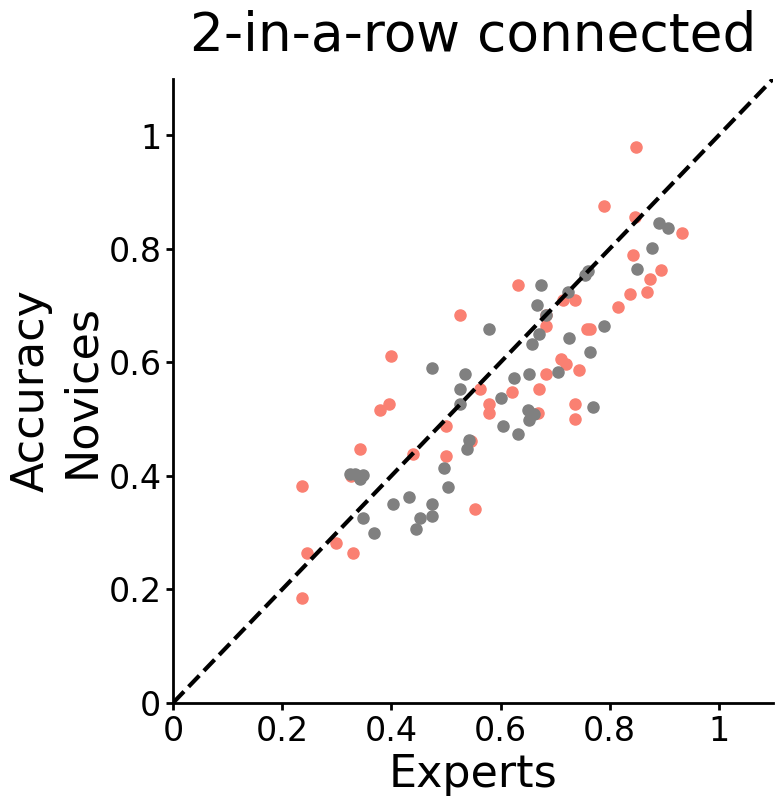

condition
expert    0.606622
novice    0.561227
Name: accuracy_2inarowconn, dtype: float64
is_real
False    0.569261
True     0.598913
Name: accuracy_2inarowconn, dtype: float64


In [620]:
plot_key('accuracy_2inarowconn',[0,1.1],'figure_rev2_2a.pdf','Accuracy\n','2-in-a-row connected')

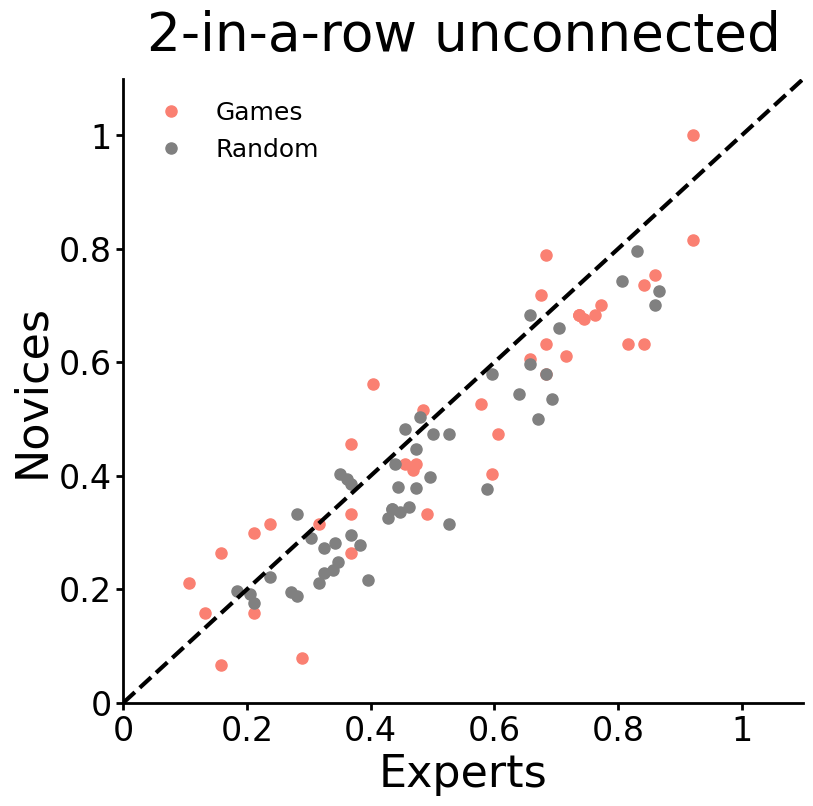

condition
expert    0.502739
novice    0.446217
Name: accuracy_2inarowunc, dtype: float64
is_real
False    0.434215
True     0.524033
Name: accuracy_2inarowunc, dtype: float64


In [621]:
plot_key('accuracy_2inarowunc',[0,1.1],'figure_rev2_2b.pdf','','2-in-a-row unconnected',True)

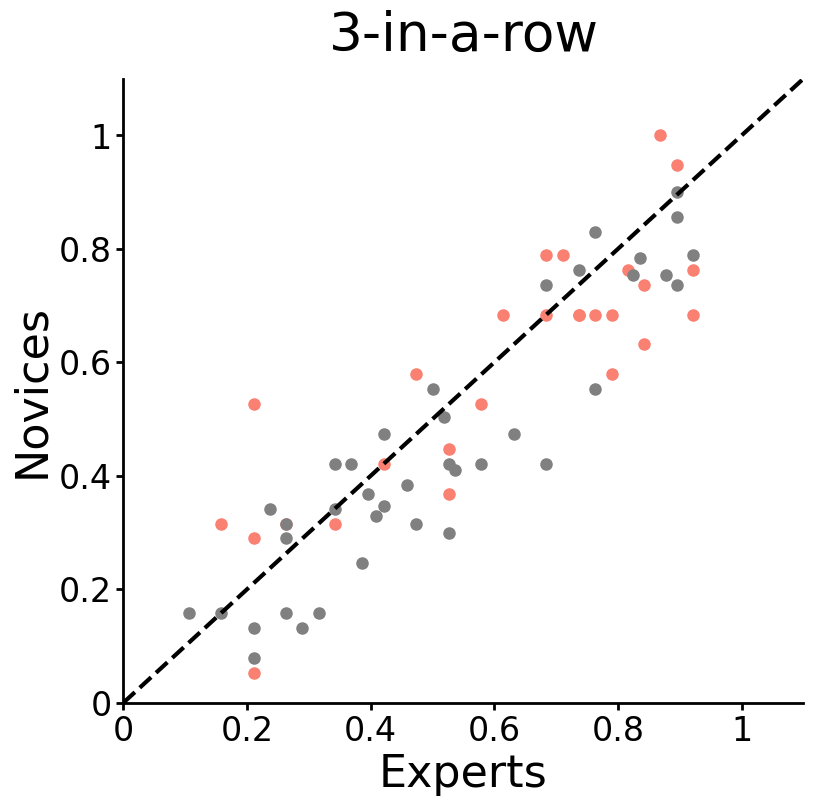

condition
expert    0.552427
novice    0.507183
Name: accuracy_3inarow, dtype: float64
is_real
False    0.480151
True     0.601527
Name: accuracy_3inarow, dtype: float64


In [622]:
plot_key('accuracy_3inarow',[0,1.1],'figure_rev2_2c.pdf','','3-in-a-row')

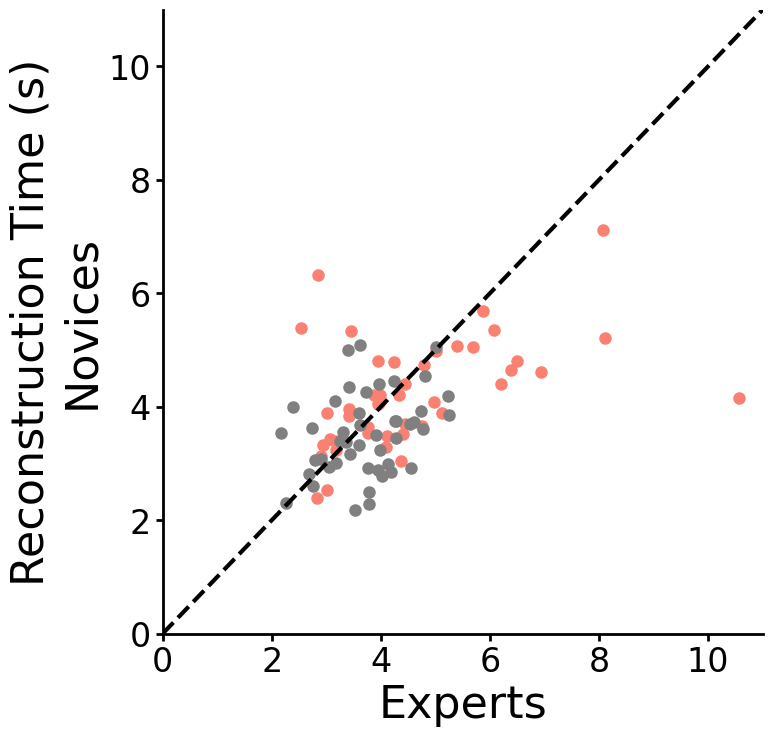

condition
expert    4.105209
novice    3.819540
Name: first_time_2inarowconn, dtype: float64
is_real
False    3.637224
True     4.314882
Name: first_time_2inarowconn, dtype: float64


In [614]:
plot_key('first_time_2inarowconn',[0,11],'figure_rev2_2d.pdf','Reconstruction Time (s)\n')

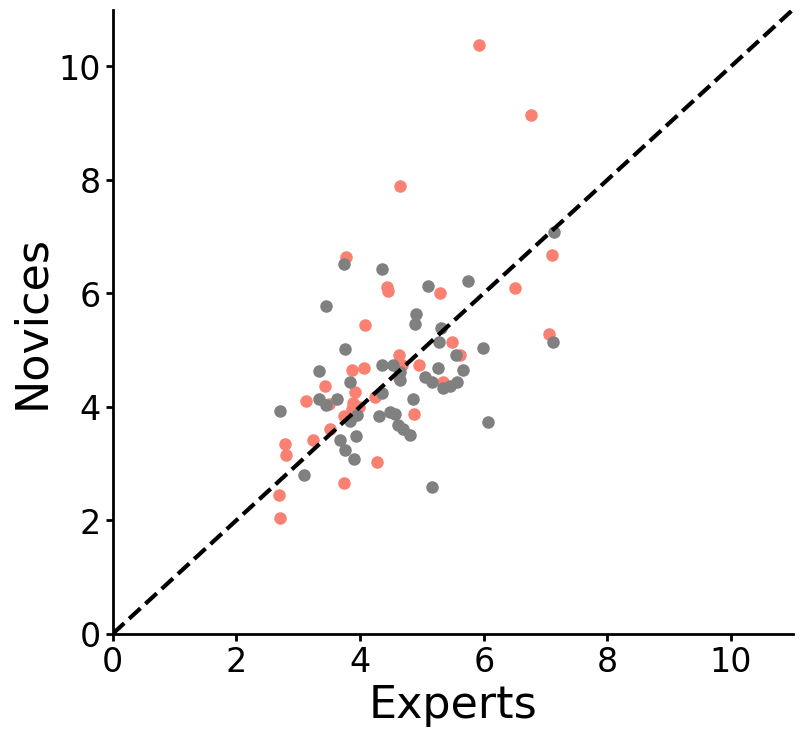

condition
expert    4.468159
novice    4.515942
Name: first_time_2inarowunc, dtype: float64
is_real
False    4.520861
True     4.447665
Name: first_time_2inarowunc, dtype: float64


In [615]:
plot_key('first_time_2inarowunc',[0,11],'figure_rev2_2e.pdf')

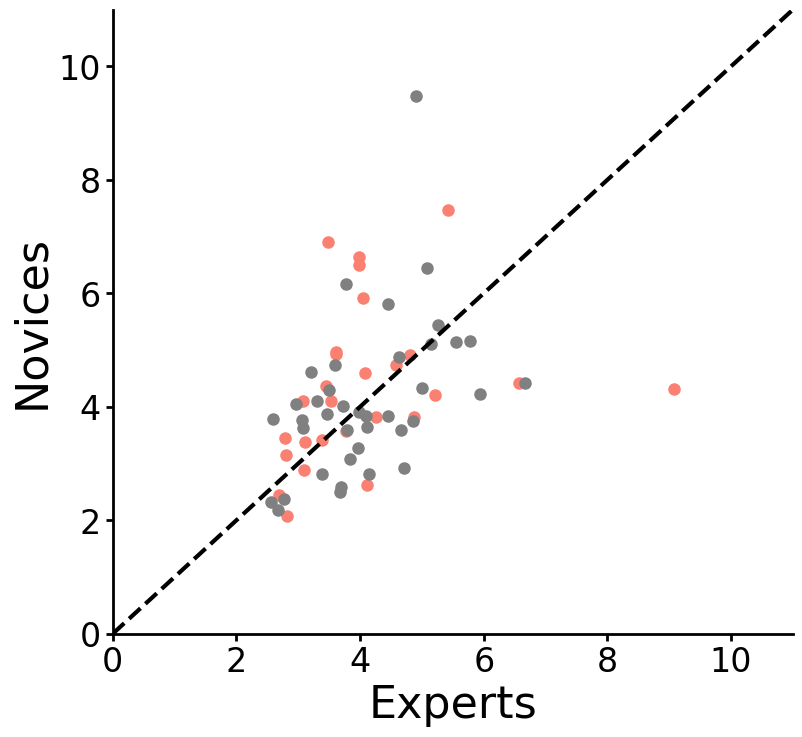

condition
expert    3.983611
novice    4.014355
Name: first_time_3inarow, dtype: float64
is_real
False    3.989065
True     4.012452
Name: first_time_3inarow, dtype: float64


In [616]:
plot_key('first_time_3inarow',[0,11],'figure_rev2_2f.pdf')

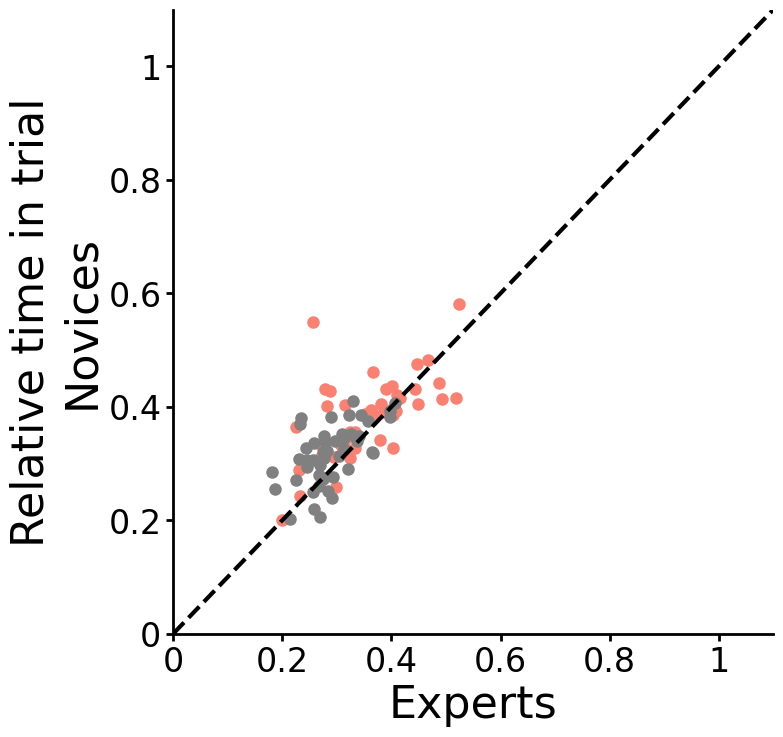

condition
expert    0.322595
novice    0.346974
Name: percent_time_2inarowconn, dtype: float64
is_real
False    0.303740
True     0.368187
Name: percent_time_2inarowconn, dtype: float64


In [623]:
plot_key('percent_time_2inarowconn',[0,1.1],'figure_rev2_2g.pdf','Relative time in trial\n')

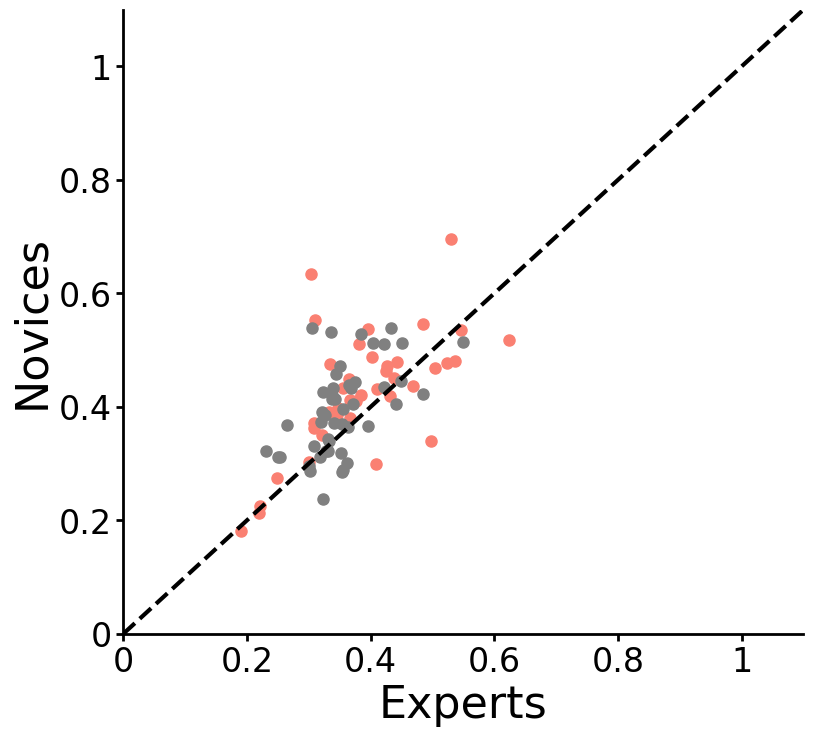

condition
expert    0.365497
novice    0.402258
Name: percent_time_2inarowunc, dtype: float64
is_real
False    0.370238
True     0.403149
Name: percent_time_2inarowunc, dtype: float64


In [624]:
plot_key('percent_time_2inarowunc',[0,1.1],'figure_rev2_2h.pdf')

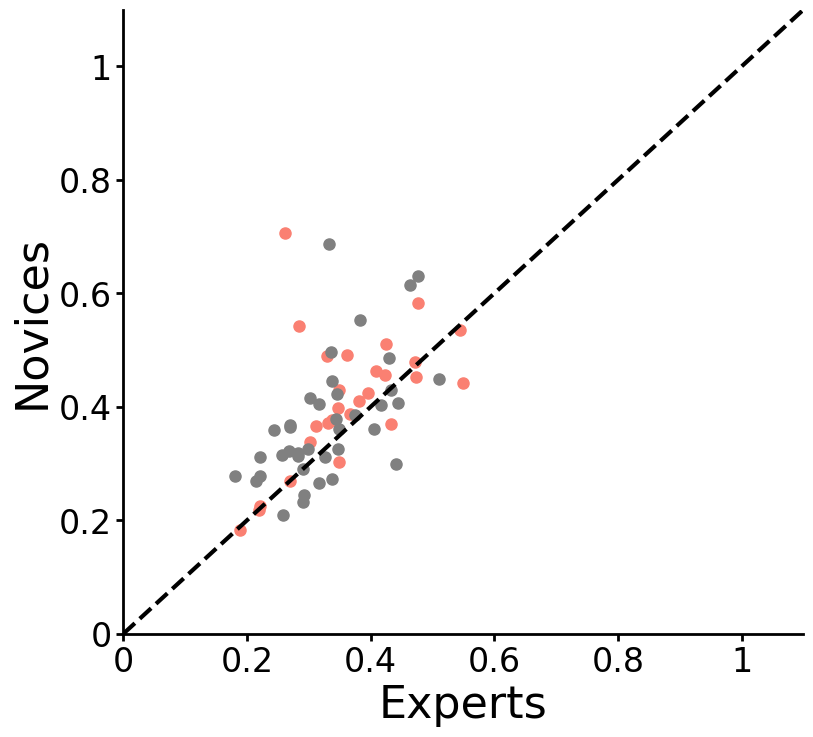

condition
expert    0.339095
novice    0.374337
Name: percent_time_3inarow, dtype: float64
is_real
False    0.338416
True     0.382203
Name: percent_time_3inarow, dtype: float64


In [625]:
plot_key('percent_time_3inarow',[0,1.1],'figure_rev2_2i.pdf')

In [600]:
#false_piece_rate = np.sum(A[:,:,1:,0],axis=2)
#missed_piece_rate = np.mean(A[:,:,0,1:],axis=2)
#wrong_color_rate = (A[:,:,2,1]+A[:,:,1,2])/2


In [548]:
import statsmodels.formula.api as sm
res = sm.ols(formula="accuracy ~ C(condition) + C(board_id)",data=df_regression).fit()
print(res.params['C(condition)[T.novice]'],
      np.mean((res.conf_int(alpha=0.05).loc['C(condition)[T.novice]'].values-res.params['C(condition)[T.novice]'])*[-1,1]),
      res.t_test('C(condition)[T.novice]').statistic,
      res.pvalues['C(condition)[T.novice]'])

-0.0005040813839987113 0.00036142768692253176 [[-2.734484]] 0.00627882054174131


In [549]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               accuracy   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     12.54
Date:                Mon, 26 Dec 2022   Prob (F-statistic):          3.42e-160
Time:                        13:37:42   Log-Likelihood:                 13809.
No. Observations:                3648   AIC:                        -2.742e+04
Df Residuals:                    3551   BIC:                        -2.682e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.9990      0.001   1100.496      0.000       0.997       1.001
C(condition)[T.novice]    -0.0005      0.000     -2.734      0.006      -0.001      -0.000
C(board_id)[T.1.0]        -0.0003      0.001     -0.229      0.819      -0.003       0.002
C(board_id)[T.2.0]        -0.0011      0.001     -0.859      0.391      -0.004       0.001
C(board_id)[T.3.0]        -0.0016      0.001     -1.259      0.208      -0.004       0.001
C(board_id)[T.4.0]        -0.0025      0.001     -1.946      0.052      -0.005    1.87e-05
C(board_id)[T.5.0]        -0.0002      0.001     -0.172      0.864      -0.003       0.002
C(board_id)[T.6.0]        -0.0029      0.001     -2.289      0.022      -0.005      -0.000
C(board_id)[T.7.0]        -0.0004      0.001     -0.343      0.731      -0.003       0.002
C(board_id)[T.8.0]        -0.0050      0.001     -3.949      0.000      -0.008      -0.003
C(board_id)[T.9.0]        -0.0042      0.001     -3.320      0.001      -0.007      -0.002
C(board_id)[T.10.0]       -0.0002      0.001     -0.172      0.864      -0.003       0.002
C(board_id)[T.11.0]       -0.0068      0.001     -5.323      0.000      -0.009      -0.004
C(board_id)[T.12.0]       -0.0026      0.001     -2.060      0.039      -0.005      -0.000
C(board_id)[T.13.0]       -0.0014      0.001     -1.087      0.277      -0.004       0.001
C(board_id)[T.14.0]       -0.0018      0.001     -1.431      0.153      -0.004       0.001
C(board_id)[T.15.0]       -0.0008      0.001     -0.630      0.529      -0.003       0.002
C(board_id)[T.16.0]       -0.0034      0.001     -2.690      0.007      -0.006      -0.001
C(board_id)[T.17.0]       -0.0042      0.001     -3.320      0.001      -0.007      -0.002
C(board_id)[T.18.0]       -0.0040      0.001     -3.148      0.002      -0.007      -0.002
C(board_id)[T.19.0]       -0.0005      0.001     -0.401      0.689      -0.003       0.002
C(board_id)[T.20.0]       -0.0016      0.001     -1.259      0.208      -0.004       0.001
C(board_id)[T.21.0]       -0.0019      0.001     -1.488      0.137      -0.004       0.001
C(board_id)[T.22.0]       -0.0073      0.001     -5.724      0.000      -0.010      -0.005
C(board_id)[T.23.0]       -0.0018      0.001     -1.374      0.170      -0.004       0.001
C(board_id)[T.24.0]       -0.0066      0.001     -5.151      0.000      -0.009      -0.004
C(board_id)[T.25.0]       -0.0115      0.001     -8.986      0.000      -0.014      -0.009
C(board_id)[T.26.0]       -0.0049      0.001     -3.835      0.000      -0.007      -0.002
C(board_id)[T.27.0]       -0.0010      0.001     -0.744      0.457      -0.003       0.002
C(board_id)[T.28.0]       -0.0046      0.001     -3.606      0.000      -0.007      -0.002
C(board_id)[T.29.0]       -0.0002      0.001     -0.172      0.864      -0.003  